# CS436 Project: 3D Scene Reconstruction
# Week 2: Two-View Reconstruction

**Group Members:**
* Choudhary Usman Alam, 26100383
* Muneeb ur Rehman, 26100346

**Objective:** Reconstruct a sparse 3D point cloud from two images using the Essential Matrix and Triangulation.

## Implementation Notes

**Key Implementation Details:**
1. **Feature Matching**: Using SIFT with Lowe's ratio test (threshold=0.85) for robust matching
2. **Essential Matrix**: Computed using RANSAC with `cv2.findEssentialMat()`
3. **Pose Recovery**: Using `cv2.recoverPose()` which automatically performs cheirality check
4. **Triangulation**: Using `cv2.triangulatePoints()` to reconstruct 3D points
5. **Critical Bug Fix**: OpenCV masks use values 0 and 255 (not 0 and 1), so we filter with `mask > 0`

## Imports and Setup

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

project_root = os.path.abspath(os.path.join('..'))
if os.path.join(project_root, 'src') not in sys.path:
    sys.path.append(os.path.join(project_root, 'src'))

from utils import load_images_from_folder, get_sift_matches, save_point_cloud_to_ply
from reconstruction import (
    get_intrinsic_matrix, 
    calculate_essential_matrix, 
    recover_camera_pose, 
    triangulate_points,
    get_inlier_points
)

import importlib
import utils as utils_mod
import reconstruction as reconstruction_mod
importlib.reload(utils_mod)
importlib.reload(reconstruction_mod)
from utils import get_dense_combined_matches, sample_colors, save_colored_point_cloud_to_ply
from reconstruction import calculate_essential_matrix_from_points

print("Libraries and modules loaded successfully.")

Libraries and modules loaded successfully.


In [2]:
DENSE = True
USE_COLOR = True
print(f"Pipeline mode: {'Dense' if DENSE else 'Standard'} | Colors: {'On' if USE_COLOR else 'Off'}")

Pipeline mode: Dense | Colors: On


## Visualization Function

In [3]:
def visualize_results(points_3d, colors=None):
    mean = np.mean(points_3d, axis=0)
    std = np.std(points_3d, axis=0)
    clean_mask = (np.abs(points_3d - mean) < 3 * std).all(axis=1)
    clean_points = points_3d[clean_mask]
    colors_clean = None
    if colors is not None:
        colors_clean = colors[clean_mask]
    print(f"Visualizing {len(clean_points)} points (after removing extreme outliers).")
    X = clean_points[:, 0]; Y = clean_points[:, 1]; Z = clean_points[:, 2]
    fig = plt.figure(figsize=(18, 6))
    ax1 = fig.add_subplot(131, projection='3d')
    if colors_clean is not None:
        ax1.scatter(X, Y, Z, c=colors_clean/255.0, s=4, alpha=0.85)
    else:
        scatter = ax1.scatter(X, Y, Z, c=Z, cmap='viridis', s=3, alpha=0.7)
        plt.colorbar(scatter, ax=ax1, shrink=0.5, aspect=5)
    ax1.set_xlabel('X'); ax1.set_ylabel('Y'); ax1.set_zlabel('Z'); ax1.set_title('3D Point Cloud')
    ax1.invert_yaxis(); ax1.view_init(elev=30, azim=-45)
    ax2 = fig.add_subplot(132)
    if colors_clean is not None:
        ax2.scatter(X, Y, c=colors_clean/255.0, s=6, alpha=0.8)
    else:
        ax2.scatter(X, Y, c=Z, cmap='viridis', s=6, alpha=0.8)
    ax2.set_xlabel('X'); ax2.set_ylabel('Y'); ax2.set_title('2D Scatter (X-Y)'); ax2.grid(True, alpha=0.3); ax2.set_aspect('equal', adjustable='box')
    ax3 = fig.add_subplot(133)
    ax3.scatter(X, Z, c='blue', s=6, alpha=0.6)
    ax3.set_xlabel('X (Horizontal)'); ax3.set_ylabel('Z (Depth)'); ax3.set_title('Top-Down (X-Z)'); ax3.grid(True, alpha=0.3)
    plt.tight_layout(); plt.show()

## Load Data

Successfully loaded 28 images from ../data
Images resized to max width: 1024px

Selected Image 16 and Image 17 for reconstruction.


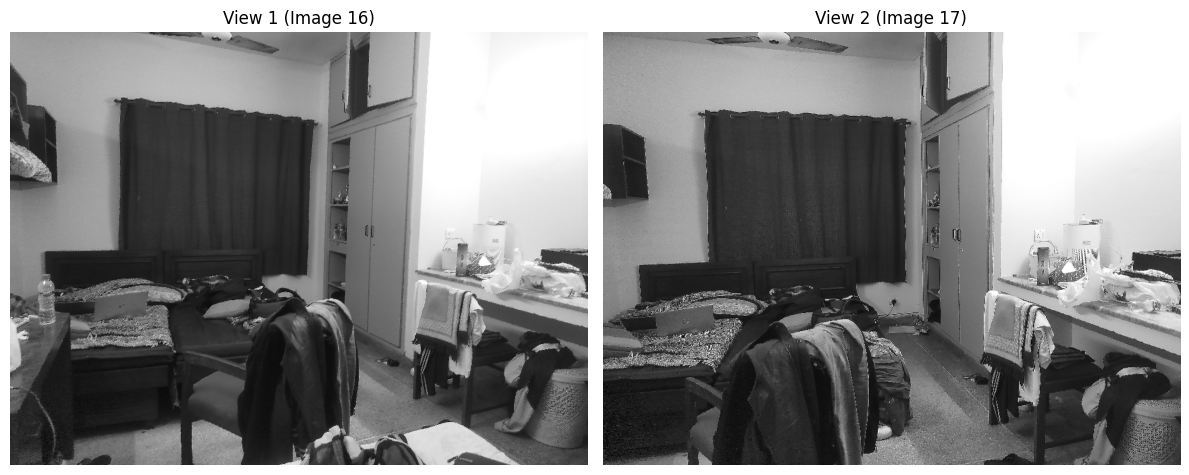

In [4]:
DATA_DIR = '../data'
images = load_images_from_folder(DATA_DIR)

IDX_1 = 16
IDX_2 = 17

if IDX_2 < len(images):
    img1 = images[IDX_1]
    img2 = images[IDX_2]

    print(f"\nSelected Image {IDX_1} and Image {IDX_2} for reconstruction.")
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1); plt.imshow(img1, cmap='gray'); plt.title(f"View 1 (Image {IDX_1})"); plt.axis('off')
    plt.subplot(1, 2, 2); plt.imshow(img2, cmap='gray'); plt.title(f"View 2 (Image {IDX_2})"); plt.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("Error: Image Index out of range.")

## The Pipeline

1. Detecting and Matching Features...
   SIFT keypoints img1/img2: 2782 / 2287
   ORB keypoints img1/img2: 7722 / 8859
   SIFT matches: 433; ORB matches: 936; Combined: 1369
2. Computing Intrinsic Matrix...
3. Computing Essential Matrix (RANSAC)...
   Inliers after RANSAC: 714
4. Recovering Camera Pose...
   Points passed Cheirality check: 711
5. Triangulating 3D Points...
   SIFT keypoints img1/img2: 2782 / 2287
   ORB keypoints img1/img2: 7722 / 8859
   SIFT matches: 433; ORB matches: 936; Combined: 1369
2. Computing Intrinsic Matrix...
3. Computing Essential Matrix (RANSAC)...
   Inliers after RANSAC: 714
4. Recovering Camera Pose...
   Points passed Cheirality check: 711
5. Triangulating 3D Points...
Saved colored point cloud to reconstruction_colored.ply

✅ SUCCESS: Reconstructed 711 3D points.
Visualizing 709 points (after removing extreme outliers).
Saved colored point cloud to reconstruction_colored.ply

✅ SUCCESS: Reconstructed 711 3D points.
Visualizing 709 points (after remo

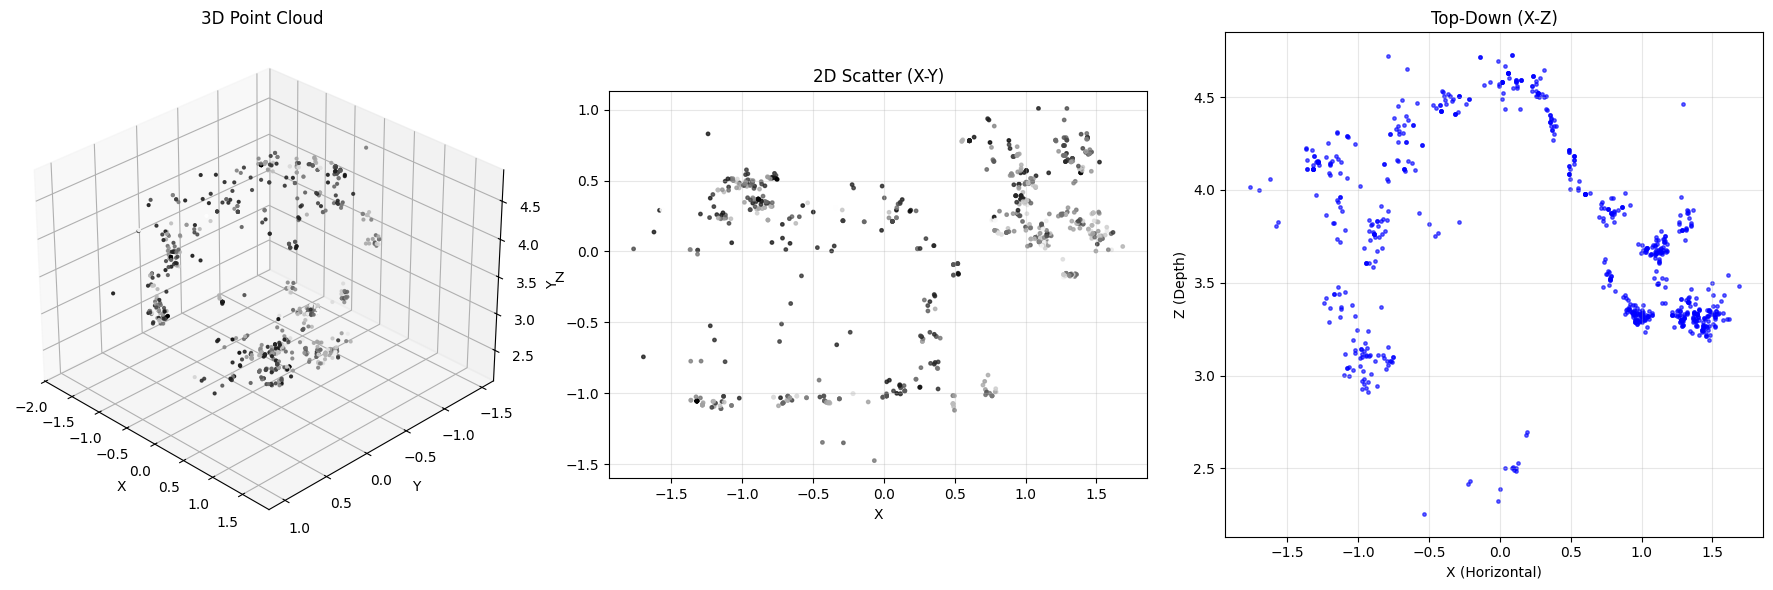

In [5]:
print("1. Detecting and Matching Features...")
if DENSE:
    from utils import get_dense_combined_matches, sample_colors, save_colored_point_cloud_to_ply
    pts1_raw, pts2_raw, stats = get_dense_combined_matches(img1, img2)
    print(f"   SIFT keypoints img1/img2: {stats['sift_keypoints_img1']} / {stats['sift_keypoints_img2']}")
    print(f"   ORB keypoints img1/img2: {stats['orb_keypoints_img1']} / {stats['orb_keypoints_img2']}")
    print(f"   SIFT matches: {stats['sift_matches']}; ORB matches: {stats['orb_matches']}; Combined: {stats['combined_matches']}")
else:
    kp1, kp2, good_matches = get_sift_matches(img1, img2)
    print(f"   Found {len(good_matches)} raw matches.")

if (DENSE and len(pts1_raw) < 10) or (not DENSE and len(good_matches) < 10):
    print("❌ ERROR: Too few matches.")
else:
    print("2. Computing Intrinsic Matrix...")
    K = get_intrinsic_matrix(img1.shape)
    print("3. Computing Essential Matrix (RANSAC)...")
    if DENSE:
        from reconstruction import calculate_essential_matrix_from_points
        E, mask, pts1, pts2 = calculate_essential_matrix_from_points(pts1_raw, pts2_raw, K)
    else:
        E, mask, pts1, pts2 = calculate_essential_matrix(kp1, kp2, good_matches, K)

    pts1_inliers, pts2_inliers = get_inlier_points(mask, pts1, pts2)
    print(f"   Inliers after RANSAC: {len(pts1_inliers)}")

    if len(pts1_inliers) < 10:
        print("❌ ERROR: RANSAC rejected too many points.")
    else:
        print("4. Recovering Camera Pose...")
        R, t, pose_mask = recover_camera_pose(E, pts1_inliers, pts2_inliers, K)
        pts1_final, pts2_final = get_inlier_points(pose_mask, pts1_inliers, pts2_inliers)
        print(f"   Points passed Cheirality check: {len(pts1_final)}")
        if len(pts1_final) > 0:
            print("5. Triangulating 3D Points...")
            points_3d = triangulate_points(R, t, K, pts1_final, pts2_final)
            if USE_COLOR:
                from utils import sample_colors, save_colored_point_cloud_to_ply
                colors = sample_colors(img1, pts1_final)
                save_colored_point_cloud_to_ply(points_3d, colors, "reconstruction_colored.ply")
            else:
                save_point_cloud_to_ply(points_3d, "reconstruction.ply")
            print(f"\n✅ SUCCESS: Reconstructed {len(points_3d)} 3D points.")
            visualize_results(points_3d, colors if USE_COLOR else None)
        else:
            print("❌ ERROR: No points passed the Cheirality check.")

## Interactive 3D Visualization (Open3D)

Open3D provides an interactive viewer where you can rotate, zoom, and inspect the point cloud in real-time. This is much more powerful than static matplotlib plots for debugging geometry.

In [6]:
try:
    import open3d as o3d
    
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points_3d)
    
    if USE_COLOR and 'colors' in locals():
        colors_normalized = colors / 255.0 if colors.max() > 1.0 else colors
        pcd.colors = o3d.utility.Vector3dVector(colors_normalized)
    else:
        z_norm = (points_3d[:, 2] - points_3d[:, 2].min()) / (points_3d[:, 2].max() - points_3d[:, 2].min())
        colors_z = plt.cm.viridis(z_norm)[:, :3]
        pcd.colors = o3d.utility.Vector3dVector(colors_z)
    
    pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))
    
    coord_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1.0, origin=[0, 0, 0])
    
    bbox = pcd.get_axis_aligned_bounding_box()
    bbox.color = (1, 0.5, 0)
    
    print(f"✨ Launching Open3D interactive viewer with {len(points_3d)} points...")
    print("   🎮 Controls:")
    print("      • Left-click + drag = Rotate view")
    print("      • Right-click + drag = Pan camera")
    print("      • Scroll wheel = Zoom in/out")
    print("      • Ctrl + Left-click = Select points")
    print("      • Press 'H' = Show all keyboard shortcuts")
    print("      • Press '-' or '+' = Adjust point size")
    print("   📐 Visual aids: Coordinate frame (RGB=XYZ), Bounding box")
    
    geometries = [pcd, coord_frame, bbox]
    o3d.visualization.draw_geometries(
        geometries,
        window_name="🔍 3D Reconstruction - Interactive View",
        width=1400,
        height=1000,
        left=50,
        top=50,
        point_show_normal=False,
        mesh_show_wireframe=False,
        mesh_show_back_face=False
    )
    
except ImportError:
    print("⚠️  Open3D not installed. Run: pip install open3d")
    print("   Skipping interactive visualization.")
except Exception as e:
    print(f"⚠️  Open3D visualization failed: {e}")
    print("   This is normal in some environments (e.g., headless servers).")

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
✨ Launching Open3D interactive viewer with 711 points...
   🎮 Controls:
      • Left-click + drag = Rotate view
      • Right-click + drag = Pan camera
      • Scroll wheel = Zoom in/out
      • Ctrl + Left-click = Select points
      • Press 'H' = Show all keyboard shortcuts
      • Press '-' or '+' = Adjust point size
   📐 Visual aids: Coordinate frame (RGB=XYZ), Bounding box
